# DSLab Homework 1 - Data Science with CO2

## Hand-in Instructions

- __Due: 23.03.2021 23h59 CET__
- `git push` your final verion to the master branch of your group's Renku repository before the due
- check if `Dockerfile`, `environment.yml` and `requirements.txt` are properly written
- add necessary comments and discussion to make your codes readable

## Carbosense

The project Carbosense establishes a uniquely dense CO2 sensor network across Switzerland to provide near-real time information on man-made emissions and CO2 uptake by the biosphere. The main goal of the project is to improve the understanding of the small-scale CO2 fluxes in Switzerland and concurrently to contribute to a better top-down quantification of the Swiss CO2 emissions. The Carbosense network has a spatial focus on the City of Zurich where more than 50 sensors are deployed. Network operations started in July 2017.

<img src="http://carbosense.wdfiles.com/local--files/main:project/CarboSense_MAP_20191113_LowRes.jpg" width="500">

<img src="http://carbosense.wdfiles.com/local--files/main:sensors/LP8_ZLMT_3.JPG" width="156">  <img src="http://carbosense.wdfiles.com/local--files/main:sensors/LP8_sensor_SMALL.jpg" width="300">

## Description of the homework

In this homework, we will curate a set of **CO2 measurements**, measured from cheap but inaccurate sensors, that have been deployed in the city of Zurich from the Carbosense project. The goal of the exercise is twofold: 

1. Learn how to deal with real world sensor timeseries data, and organize them efficiently using python dataframes.

2. Apply data science tools to model the measurements, and use the learned model to process them (e.g., detect drifts in the sensor measurements). 

The sensor network consists of 46 sites, located in different parts of the city. Each site contains three different sensors measuring (a) **CO2 concentration**, (b) **temperature**, and (c) **humidity**. Beside these measurements, we have the following additional information that can be used to process the measurements: 

1. The **altitude** at which the CO2 sensor is located, and the GPS coordinates (latitude, longitude).

2. A clustering of the city of Zurich in 17 different city **zones** and the zone in which the sensor belongs to. Some characteristic zones are industrial area, residential area, forest, glacier, lake, etc.

## Prior knowledge

The average value of the CO2 in a city is approximately 400 ppm. However, the exact measurement in each site depends on parameters such as the temperature, the humidity, the altitude, and the level of traffic around the site. For example, sensors positioned in high altitude (mountains, forests), are expected to have a much lower and uniform level of CO2 than sensors that are positioned in a business area with much higher traffic activity. Moreover, we know that there is a strong dependence of the CO2 measurements, on temperature and humidity.

Given this knowledge, you are asked to define an algorithm that curates the data, by detecting and removing potential drifts. **The algorithm should be based on the fact that sensors in similar conditions are expected to have similar measurements.** 

## To start with

The following csv files in the `../data/carbosense-raw/` folder will be needed: 

1. `CO2_sensor_measurements.csv`
    
   __Description__: It containts the CO2 measurements `CO2`, the name of the site `LocationName`, a unique sensor identifier `SensorUnit_ID`, and the time instance in which the measurement was taken `timestamp`.
    
2. `temperature_humidity.csv`

   __Description__: It contains the temperature and the humidity measurements for each sensor identifier, at each timestamp `Timestamp`. For each `SensorUnit_ID`, the temperature and the humidity can be found in the corresponding columns of the dataframe `{SensorUnit_ID}.temperature`, `{SensorUnit_ID}.humidity`.
    
3. `sensor_metadata.csv`

   __Description__: It contains the name of the site `LocationName`, the zone index `zone`, the altitude in meters `altitude`, the longitude `lon`, and the latitude `lat`. 

Import the following python packages:

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import plotly.express as px
import plotly.graph_objects as go
import os

In [2]:
pd.options.mode.chained_assignment = None

## PART I: Handling time series with pandas (10 points)

### a) **8/10**

Merge the `CO2_sensor_measurements.csv`, `temperature_humidity.csv`, and `sensors_metadata.csv`, into a single dataframe. 

* The merged dataframe contains:
    - index: the time instance `timestamp` of the measurements
    - columns: the location of the site `LocationName`, the sensor ID `SensorUnit_ID`, the CO2 measurement `CO2`, the `temperature`, the `humidity`, the `zone`, the `altitude`, the longitude `lon` and the latitude `lat`.

| timestamp | LocationName | SensorUnit_ID | CO2 | temperature | humidity | zone | altitude | lon | lat |
|:---------:|:------------:|:-------------:|:---:|:-----------:|:--------:|:----:|:--------:|:---:|:---:|
|    ...    |      ...     |      ...      | ... |     ...     |    ...   |  ... |    ...   | ... | ... |



* For each measurement (CO2, humidity, temperature), __take the average over an interval of 30 min__. 

* If there are missing measurements, __interpolate them linearly__ from measurements that are close by in time.

__Hints__: The following methods could be useful

1. ```python 
pandas.DataFrame.resample()
``` 
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html
    
2. ```python
pandas.DataFrame.interpolate()
```
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html
    
3. ```python
pandas.DataFrame.mean()
```
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.mean.html
    
4. ```python
pandas.DataFrame.append()
```
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.append.html

### Import and check basic characteritics of raw data

In [3]:
!git lfs pull #import lfs files

In [4]:
root = '../data/carbosense-raw'

co2_measurements = os.path.join(root, 'CO2_sensor_measurements.csv')
df_co2_raw = pd.read_csv(co2_measurements, sep='\t')

humidity_measurements = os.path.join(root, 'temperature_humidity.csv')
df_humidity_raw = pd.read_csv(humidity_measurements, sep='\t')

sensors_meta = os.path.join(root, 'sensors_metadata.csv')
df_sensor_raw = pd.read_csv(sensors_meta, sep='\t')

In [5]:
print(df_co2_raw.head(3))
df_co2_raw.describe()

             timestamp LocationName  SensorUnit_ID         CO2
0  2017-10-01 00:05:00         ZGHD           1014  593.321562
1  2017-10-01 00:15:00         ZGHD           1014  595.846258
2  2017-10-01 00:25:00         ZGHD           1014  595.845353


SensorUnit_ID            CO2
count  188966.000000  188966.000000
mean     1121.615714     471.234182
std        96.411069     108.642813
min      1014.000000     309.008819
25%      1043.000000     418.609166
50%      1113.000000     448.431301
75%      1179.000000     496.673534
max      1299.000000    7733.004603

In [6]:
df_humidity_raw.head(3)

Timestamp  1014.temperature  1014.humidity  1015.temperature  \
0  2017-10-01 00:00:00             11.39      92.262787             10.55   
1  2017-10-01 00:10:00             11.39      92.579407             10.48   
2  2017-10-01 00:20:00             11.41      92.480225             10.51   

   1015.humidity  1016.temperature  1016.humidity  1017.temperature  \
0      91.949982             11.02      92.613739             11.05   
1      92.079681             11.04      93.063873             11.05   
2      92.583221             11.06      93.201202             11.02   

   1017.humidity  1018.temperature  ...  1291.temperature  1291.humidity  \
0      89.811844             11.38  ...             10.13      96.828979   
1      90.042633             11.38  ...             10.12      97.322983   
2      89.888138             11.35  ...             10.14      97.780746   

   1292.temperature  1292.humidity  1297.temperature  1297.humidity  \
0             10.50      95.858139             10.70      94.524902   
1             10.45      95.903915             10.53      94.395203   
2             10.43      95.343155             10.45      94.620270   

   1298.temperature  1298.humidity  1299.temperature  1299.humidity  
0             11.35      90.288681             11.44      90.118927  
1             11.35      90.422195             11.46      90.073151  
2             11.33      91.023010             11.41      89.466614  

[3 rows x 93 columns]

In [7]:
df_humidity_raw.describe()

1014.temperature  1014.humidity  1015.temperature  1015.humidity  \
count       3991.000000    3991.000000       4194.000000    4194.000000   
mean          12.599564      76.205722         11.856102      77.515895   
std            3.903663      11.171054          5.353115      15.289874   
min            2.780000      35.837692         -0.790000      33.989471   
25%            9.885000      67.576927          8.292500      66.726727   
50%           12.020000      77.751678         10.575000      81.703705   
75%           15.145000      85.809273         14.897500      90.316814   
max           25.160000      95.974487         28.770000      97.614807   

       1016.temperature  1016.humidity  1017.temperature  1017.humidity  \
count       4456.000000    4456.000000       4304.000000    4304.000000   
mean          12.200474      77.795009         12.426215      75.820078   
std            4.201613      13.000721          4.225880      10.962474   
min            1.620000      32.227081          2.000000      37.058395   
25%            9.240000      68.022770          9.610000      68.134350   
50%           11.435000      80.052895         11.590000      77.775520   
75%           14.822500      88.612598         14.900000      84.881824   
max           23.760000      97.429794         27.340000      93.534988   

       1018.temperature  1018.humidity  ...  1291.temperature  1291.humidity  \
count       4139.000000    4139.000000  ...       4413.000000    4413.000000   
mean          12.585917      75.380505  ...         11.216655      81.974537   
std            4.060469      11.651615  ...          4.821004      14.207320   
min            2.520000      34.245056  ...         -0.510000      31.830353   
25%            9.830000      66.394371  ...          8.120000      73.236984   
50%           11.930000      77.484650  ...         10.220000      84.856552   
75%           15.220000      85.388702  ...         13.610000      93.769592   
max           24.780000      95.884842  ...         27.880000     101.488632   

       1292.temperature  1292.humidity  1297.temperature  1297.humidity  \
count       4448.000000    4448.000000       4454.000000    4454.000000   
mean          11.283743      83.102482         11.869728      79.855228   
std            5.600442      16.202051          5.849123      16.147332   
min           -1.410000      31.271500         -0.630000      33.682388   
25%            7.627500      71.590942          7.940000      68.491978   
50%            9.970000      88.509125         10.295000      84.246201   
75%           14.490000      96.932930         15.547500      94.185871   
max           30.390000     103.485626         28.690000     100.655121   

       1298.temperature  1298.humidity  1299.temperature  1299.humidity  
count       3912.000000    3912.000000       4418.000000    4418.000000  
mean          12.812004      74.269393         12.761057      75.287949  
std            4.866946      12.945248          4.065574      10.442040  
min            1.990000      32.326263          2.370000      34.706635  
25%            9.550000      65.655273          9.650000      67.300362  
50%           11.580000      77.135605         12.050000      75.741333  
75%           15.290000      84.908527         15.840000      84.221882  
max           29.840000      93.708557         22.700000      94.297928  

[8 rows x 92 columns]

In [8]:
print(df_sensor_raw.head(3))
df_sensor_raw.describe()

  LocationName  zone  altitude       lat      lon
0         AJGR     2     627.8  47.33321  8.48030
1         BSCR     2     462.3  47.35581  8.43007
2         BUDF    10     490.2  47.36270  8.43311


zone    altitude        lat        lon
count  46.000000   46.000000  46.000000  46.000000
mean    3.978261  467.110870  47.381717   8.520535
std     2.992503   92.549221   0.028782   0.043520
min     1.000000  391.900000  47.323340   8.430070
25%     2.000000  410.550000  47.358785   8.504433
50%     2.000000  433.400000  47.382844   8.523835
75%     5.000000  478.025000  47.405260   8.543759
max    14.000000  863.600000  47.434277   8.603844

### Process temperature_humidity.csv

In [9]:
#get the list of all the SensorUnit_ID
ID_list=df_co2_raw.SensorUnit_ID.unique()


#check that the columns are a succesion of temperature and humidity
#and also check that two successive temperature->humidity are associated to the same sensorUnit_id
#and that the sensorUnit_ID exists in the table df_co2_raw
prev_number=0
for idx,s in enumerate(df_humidity_raw.columns[1:].values):
    if idx%2==0:
        prev_number=int(s.split('.')[0])
        assert prev_number in ID_list
        assert s.split('.')[1]=="temperature"
    else:
        assert prev_number==int(s.split('.')[0])
        assert s.split('.')[1]=="humidity"


#generate a DatetimeIndex from the columns Timestamp
time_index=pd.to_datetime(df_humidity_raw['Timestamp'])

#set DatetimeIndex, interpolate, and resample every 30minutes
df_humidity_30MinAvg=df_humidity_raw\
                        .set_index(time_index)\
                        .interpolate(method='time', axis=0)\
                        .resample('30T').mean()
    
#verify that there are no null values remaining
assert not df_humidity_30MinAvg.isnull().any().any()

#generate a DatetimeIndex from the columns Timestamp
_30Min_time_index=df_humidity_30MinAvg.index

#create list of data frames
df_list = np.empty(ID_list.size,dtype="object")

for i,sensor_id in enumerate(ID_list):#for each sensor
    
    #create the dataframe for one particular sensor
    df = pd.DataFrame(data={'timestamp':     _30Min_time_index,
                            'SensorUnit_ID': [sensor_id]*df_humidity_30MinAvg.shape[0],
                            'humidity':      df_humidity_30MinAvg[str(sensor_id)+".humidity"].values, 
                            'temperature':   df_humidity_30MinAvg[str(sensor_id)+".temperature"].values})
    
    df_list[i]=df#add it to the list

#concatenate all dataframe for each sensor into one
df_humi_temp=pd.concat(df_list, ignore_index=True)

#check that the size corresponds and therefore the concatenation is good as well
assert df_humi_temp.shape[0]==df_humidity_30MinAvg.shape[0]*ID_list.size

df_humi_temp

timestamp  SensorUnit_ID   humidity  temperature
0     2017-10-01 00:00:00           1014  92.440806    11.396667
1     2017-10-01 00:30:00           1014  91.625097    11.303333
2     2017-10-01 01:00:00           1014  91.096761    11.240000
3     2017-10-01 01:30:00           1014  91.275734    11.260000
4     2017-10-01 02:00:00           1014  91.003937    11.285000
...                   ...            ...        ...          ...
68443 2017-10-31 21:30:00           1299  78.965388     3.923333
68444 2017-10-31 22:00:00           1299  79.702896     3.766667
68445 2017-10-31 22:30:00           1299  80.769740     3.493333
68446 2017-10-31 23:00:00           1299  81.676366     3.373333
68447 2017-10-31 23:30:00           1299  81.910970     3.286667

[68448 rows x 4 columns]

### Process CO2_sensor_measurements.csv

In [10]:
#create list of data frames
df_list = np.empty(ID_list.size,dtype="object")

for i,sensor_id in enumerate(ID_list):#for each sensor
    
    #isolate one sensor
    one_particular_sensor=df_co2_raw[df_co2_raw["SensorUnit_ID"]==sensor_id]
    
    #get the LocationName
    locationName=one_particular_sensor["LocationName"].values[0]
    
    #create the dataframe for one particular sensor
    #interpolate,resample and interpolate again in case
    #there were no data over a 30min interval
    df = pd.DataFrame(data={'CO2': one_particular_sensor["CO2"].values},
                 index=pd.to_datetime(one_particular_sensor["timestamp"]))\
            .interpolate(method='time', axis=0).resample('30T').mean()\
            .interpolate(method='time', axis=0)
    df=df.assign(SensorUnit_ID=[sensor_id]*df.shape[0],LocationName=[locationName]*df.shape[0])
    
    df_list[i]=df#add it to the list

#concatenate each sensor's dataframe into one general dataframe
df_co2=pd.concat(df_list)

#verify that there are no null values
assert not df_co2.isnull().any().any()

df_co2

CO2  SensorUnit_ID LocationName
timestamp                                                  
2017-10-01 00:00:00  595.004391           1014         ZGHD
2017-10-01 00:30:00  597.017879           1014         ZGHD
2017-10-01 01:00:00  596.487010           1014         ZGHD
2017-10-01 01:30:00  598.787639           1014         ZGHD
2017-10-01 02:00:00  595.366394           1014         ZGHD
...                         ...            ...          ...
2017-10-31 21:30:00  477.307329           1299         ZLDW
2017-10-31 22:00:00  474.396830           1299         ZLDW
2017-10-31 22:30:00  474.406102           1299         ZLDW
2017-10-31 23:00:00  477.910252           1299         ZLDW
2017-10-31 23:30:00  471.881151           1299         ZLDW

[66667 rows x 3 columns]

### Join the 3 tables

In [11]:
#merge the CO2 data with the sensor metadata
#and then merge with the temperature and humidity
data=df_humi_temp.merge(pd.merge(df_co2,df_sensor_raw,on="LocationName",how='left').set_index(df_co2.index),
                   on=["timestamp","SensorUnit_ID"])\
                .set_index("timestamp")#set the timestamp as index

#check if no value is missing
assert not data.isnull().any().any()

data

SensorUnit_ID   humidity  temperature         CO2  \
timestamp                                                                
2017-10-01 00:00:00           1014  92.440806    11.396667  595.004391   
2017-10-01 00:30:00           1014  91.625097    11.303333  597.017879   
2017-10-01 01:00:00           1014  91.096761    11.240000  596.487010   
2017-10-01 01:30:00           1014  91.275734    11.260000  598.787639   
2017-10-01 02:00:00           1014  91.003937    11.285000  595.366394   
...                            ...        ...          ...         ...   
2017-10-31 21:30:00           1299  78.965388     3.923333  477.307329   
2017-10-31 22:00:00           1299  79.702896     3.766667  474.396830   
2017-10-31 22:30:00           1299  80.769740     3.493333  474.406102   
2017-10-31 23:00:00           1299  81.676366     3.373333  477.910252   
2017-10-31 23:30:00           1299  81.910970     3.286667  471.881151   

                    LocationName  zone  altitude        lat       lon  
timestamp                                                              
2017-10-01 00:00:00         ZGHD     2     413.5  47.370446  8.523256  
2017-10-01 00:30:00         ZGHD     2     413.5  47.370446  8.523256  
2017-10-01 01:00:00         ZGHD     2     413.5  47.370446  8.523256  
2017-10-01 01:30:00         ZGHD     2     413.5  47.370446  8.523256  
2017-10-01 02:00:00         ZGHD     2     413.5  47.370446  8.523256  
...                          ...   ...       ...        ...       ...  
2017-10-31 21:30:00         ZLDW     5     405.9  47.348870  8.536290  
2017-10-31 22:00:00         ZLDW     5     405.9  47.348870  8.536290  
2017-10-31 22:30:00         ZLDW     5     405.9  47.348870  8.536290  
2017-10-31 23:00:00         ZLDW     5     405.9  47.348870  8.536290  
2017-10-31 23:30:00         ZLDW     5     405.9  47.348870  8.536290  

[66667 rows x 9 columns]

### b) **2/10** 

Export the curated and ready to use timeseries to a csv file, and properly push the merged csv to Git LFS.

In [12]:
#Don't run it, I've already done it
'''
data.to_csv("processed_data.csv")

!git lfs status
!git lfs track "processed_data.csv"
!git add .gitattributes
!git add processed_data.csv
!git commit -m"added processed_data.csv into lfs"
!git push
!git lfs status
'''

'\ndata.to_csv("processed_data.csv")\n\n!git lfs status\n!git lfs track "processed_data.csv"\n!git add .gitattributes\n!git add processed_data.csv\n!git commit -m"added processed_data.csv into lfs"\n!git push\n!git lfs status\n'

## PART II: Data visualization (15 points)

### a) **5/15** 
Group the sites based on their altitude, by performing K-means clustering. 
- Find the optimal number of clusters using the [Elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)). 
- Wite out the formula of metric you use for Elbow curve. 
- Perform clustering with the optimal number of clusters and add an additional column `altitude_cluster` to the dataframe of the previous question indicating the altitude cluster index. 
- Report your findings.

__Note__: [Yellowbrick](http://www.scikit-yb.org/) is a very nice Machine Learning Visualization extension to scikit-learn, which might be useful to you. 

In [13]:
!git lfs pull #import lfs files <- just in case you did not run Part I

data = pd.read_csv('processed_data.csv', sep=',')
data.head(3)

timestamp  SensorUnit_ID   humidity  temperature         CO2  \
0  2017-10-01 00:00:00           1014  92.440806    11.396667  595.004391   
1  2017-10-01 00:30:00           1014  91.625097    11.303333  597.017879   
2  2017-10-01 01:00:00           1014  91.096761    11.240000  596.487010   

  LocationName  zone  altitude        lat       lon  
0         ZGHD     2     413.5  47.370446  8.523256  
1         ZGHD     2     413.5  47.370446  8.523256  
2         ZGHD     2     413.5  47.370446  8.523256

In [14]:
#isolate pairs of locations with their altitude
pairs_location_altitude=data[["LocationName","altitude"]].drop_duplicates().reset_index().drop(columns="index")#.values

#check that we found every locations
assert pairs_location_altitude.shape[0]==ID_list.size

print("5 firsts:\n",
pairs_location_altitude[:5])

5 firsts:
   LocationName  altitude
0         ZGHD     413.5
1         ZORL     439.9
2         ZTBN     402.9
3         ZHRG     410.5
4         ZSCH     413.1


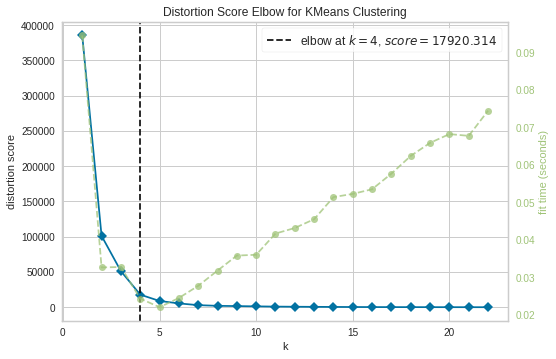

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [15]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

#altitude list
altitudes=pairs_location_altitude["altitude"].values.reshape(-1,1)

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,ID_list.size//2))

visualizer.fit(altitudes)        # Fit the data to the visualizer
visualizer.show()        

As suggested by the graph, 4 clusters is indeed a good choice


The scoring method used by the model is defined as the sum of squared distances between each observation and its closest centroid


i.e. the formula is $$\sum_{c \in Cluster\_Centers}\sum_{a \in Altitudes\_List}||a-c||^2 \cdot \mathbb{1}_{\text{c is the closet center to a}}$$

In [16]:
kmeans = KMeans(n_clusters=4)

#get the cluster index for each altitude
labels=kmeans.fit_predict(altitudes)

#associate the cluster id to each sensor
pairs_location_altitude["altitude_cluster"]=labels

#merge with the altitude cluster by merging on the LocationName
data=data.merge(pairs_location_altitude[["LocationName","altitude_cluster"]],on="LocationName",how='left')

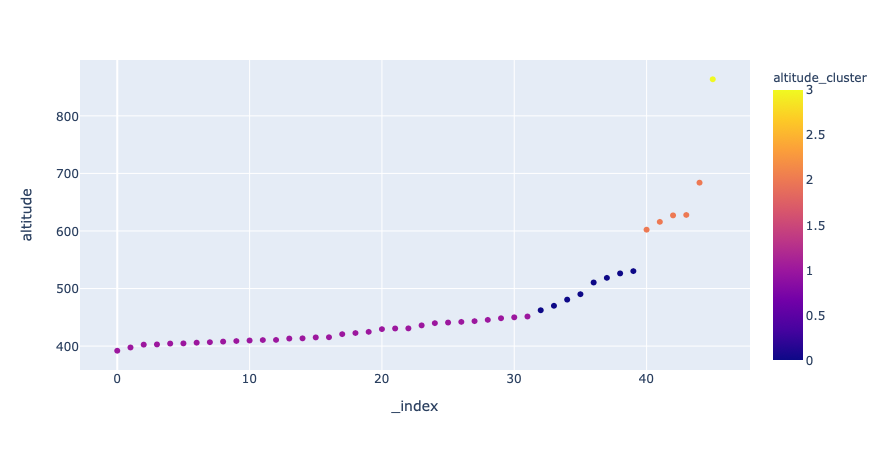

In [17]:
#plot the altitude and color them by cluster centers
px.scatter(pairs_location_altitude.sort_values(by="altitude").reset_index(),y="altitude",color="altitude_cluster")

We can see that there are about 2 distinct clusters and 1 outlier. The lower cluster span over a large range of values and can be split in two to sufficiently lower the score metric which resulted into 3 clusters and 1 outlier for a total of 4 clusters

### b) **4/15** 

Use `plotly` (or other similar graphing libraries) to create an interactive plot of the monthly median CO2 measurement for each site with respect to the altitude. 

Add proper title and necessary hover information to each point, and give the same color to stations that belong to the same altitude cluster.

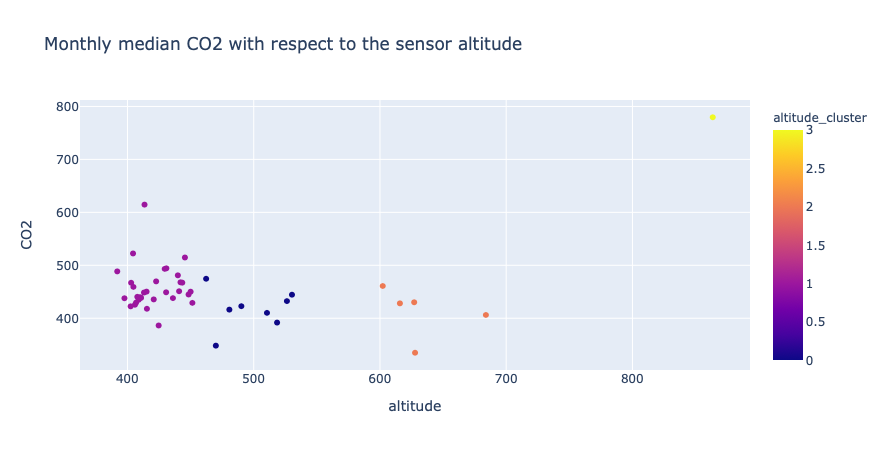

In [18]:
#The data is over only one month
px.scatter(data[["CO2","SensorUnit_ID","altitude","altitude_cluster"]].set_index(pd.to_datetime(data["timestamp"]))\
                                                                      .groupby("SensorUnit_ID").resample('1M').median()\
                                                                      .droplevel("SensorUnit_ID")
           ,x="altitude",y="CO2",color="altitude_cluster",title="Monthly median CO2 with respect to the sensor altitude"
           ,hover_name="SensorUnit_ID", hover_data={'CO2':':.1f',
                                                    'altitude':':.1f',
                                                    'altitude_cluster':False})

### c) **6/15**

Use `plotly` (or other similar graphing libraries) to plot an interactive time-varying density heatmap of the mean daily CO2 concentration for all the stations. Add proper title and necessary hover information.

__Hints:__ Check following pages for more instructions:
- [Animations](https://plotly.com/python/animations/)
- [Density Heatmaps](https://plotly.com/python/mapbox-density-heatmaps/)

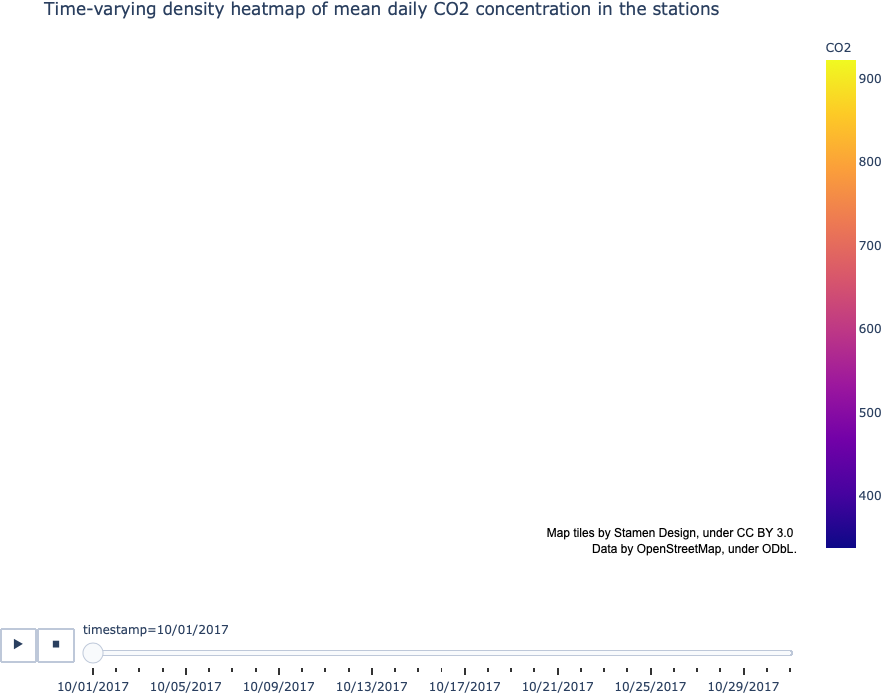

In [19]:
# Keep all useful information to print on hoover and aggregate the data by day mean
agg_data = data[['SensorUnit_ID', 'CO2', 'lat', 'lon', 'LocationName', 'zone', 'altitude', 'humidity', 'temperature']]\
        .set_index(pd.to_datetime(data["timestamp"])).groupby('SensorUnit_ID').resample('1D').mean().droplevel('SensorUnit_ID').reset_index()
agg_data['timestamp'] = agg_data['timestamp'].apply(lambda x: x.strftime("%m/%d/%Y"))

fig = px.density_mapbox(agg_data, lat='lat', lon='lon', z='CO2', zoom=11,\
                        animation_frame='timestamp', animation_group='SensorUnit_ID',\
                        title='Time-varying density heatmap of mean daily CO2 concentration in the stations',\
                        height=700, hover_name='SensorUnit_ID', hover_data={'CO2':':.1f',
                                                    'altitude':':.1f',
                                                    'humidity':':.1f',
                                                    'temperature':':.1f',
                                                    'zone':':d'})
fig.update_layout(mapbox_style='stamen-terrain', margin={"r":0,"t":30,"l":0,"b":0})
fig.show()

## PART III: Model fitting for data curation (35 points)

### a) **2/35**

The domain experts in charge of these sensors report that one of the CO2 sensors `ZSBN` is exhibiting a drift on Oct. 24. Verify the drift by visualizing the CO2 concentration of the drifting sensor and compare it with some other sensors from the network. 

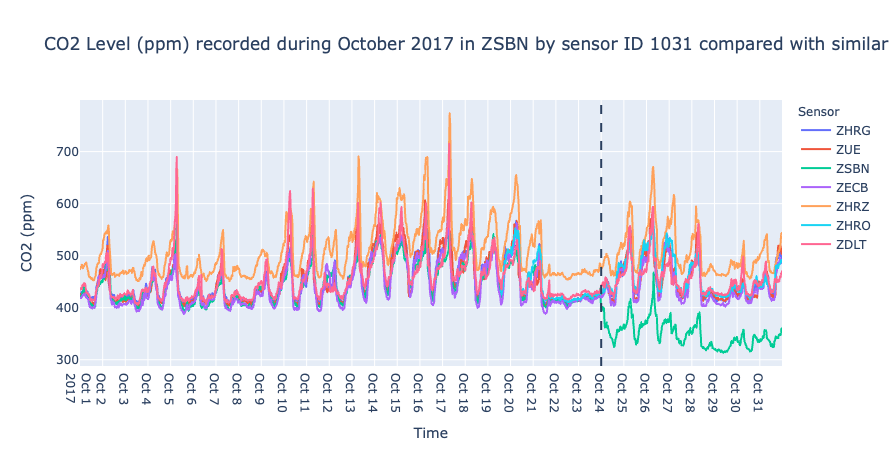

In [20]:
# covert the 'timestamp' column to datatime type
data['timestamp'] = pd.to_datetime(data['timestamp'])

# create pd.series for conditions on the Location Name and Period
ZSBN = data['LocationName']=='ZSBN'
October = data['timestamp'].apply(lambda x: x.month) == 10

# collect all the useful information on the ZSBN sensor
ID = data[ZSBN]['SensorUnit_ID'].unique()[0]
lat = data[ZSBN]['lat'].unique()
lon = data[ZSBN]['lon'].unique()
altitude = data[ZSBN]['altitude_cluster'].unique()
zone = data[ZSBN]['zone'].unique()


# create pd.series for conditions on the Lat, Lon and Zone and altitude to define similar sensors

# We define 'similar sensors' 2 sensors:
# - in the same cluster of altitude 
# - in the same geographical area (similar lon and lon) or zone

close_lat = data['lat'].apply(lambda x: abs(x-lat) < 0.032 )
close_lon = data['lon'].apply(lambda x: abs(x-lon) < 0.032 )
same_zone = data['zone'].apply(lambda x: abs(x-zone) == 0 )
close_alt = data['altitude_cluster'].apply(lambda x: abs(x-altitude) == 0 )

# plot
fig = px.line(data[October & (same_zone | (close_lon & close_lat)) & close_alt],
            x='timestamp',
            y='CO2',
            color='LocationName',
            labels={
                'timestamp':'Time',
                'CO2':'CO2 (ppm)',
                'LocationName':'Sensor'
            }, 
            title='CO2 Level (ppm) recorded during October 2017 in ZSBN by sensor ID '+str(ID)+' compared with similar sensors'
           )
fig.update_xaxes(
    dtick=24*60*60*1000
)
fig.add_vline(
    x='2017-10-24', line_dash='dash'
)
fig.update_layout(

    hovermode='x unified'
)
fig.show()

### b) **8/35**

The domain experts ask you if you could reconstruct the CO2 concentration of the drifting sensor had the drift not happened. You decide to:
- Fit a linear regression model to the CO2 measurements of the site, by considering as features the covariates not affected by the malfunction (such as temperature and humidity)
- Create an interactive plot with `plotly` (or other similar graphing libraries):
    - the actual CO2 measurements
    - the values obtained by the prediction of the linear model for the entire month of October
    - the __confidence interval__ obtained from cross validation
- What do you observe? Report your findings.

__Note:__ Cross validation on time series is different from that on other kinds of datasets. The following diagram illustrates the series of training sets (in orange) and validation sets (in blue). For more on time series cross validation, there are a lot of interesting articles available online. scikit-learn provides a nice method [`sklearn.model_selection.TimeSeriesSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html).

![ts_cv](https://player.slideplayer.com/86/14062041/slides/slide_28.jpg)

In [21]:
# create the datasets
X = data[ZSBN & October].set_index('timestamp')[['humidity','temperature']]
y = data[ZSBN & October].set_index('timestamp')['CO2']
X_train = X[ X.index.day<24 ]
y_train = y[ X.index.day<24 ]

period = data[ZSBN & October]['timestamp']


# Prediction
linear_model = sk.linear_model.LinearRegression()
linear_model.fit(X_train,y_train)
y_pred = linear_model.predict(X)

In [22]:
def estimate_stdev(X_train, y_train=y_train, k=100):
    '''
        Estimate Standard Deviation of the prediction through Cross Validation
        
        Input: X_train = features of the training set (pd.Dataframe)
               y_train = target of the training set (pd.Series)
               k = number of folds (scalar)
        Output: mean of the unbiased Standard Error estimator for the prediction of each model in the Cross Validation (scalar)
    '''
    tscv = sk.model_selection.TimeSeriesSplit(n_splits=k)
    stdev = 0
    for train_index, test_index in tscv.split(X_train):
        X_train_CV, X_test_CV = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_CV, y_test_CV = y_train.iloc[train_index], y_train.iloc[test_index]
        linear_model.fit(X_train_CV,y_train_CV)
        stdev += np.sqrt( sum((linear_model.predict(X_test_CV) - y_test_CV)**2) / (len(y_test_CV)-1)) 
    stdev /= k
    print('Standard deviation prediction: {}'.format(stdev))
    print('95% Confident interval Prediction size: {} ppm'.format(stdev*1.96*2))
    
    return stdev


def plot_predicted_CO2(predicted, stdev, measured=data[ZSBN]['CO2'], period=period):
    '''
        Plot the CO2 Level (ppm) recorded and predicted (95% CI) in October 2017 in ZSBN
        
        Input: measured = measured level of CO2 by sensor ID 1031 in ZSBN (pd.Series)
               predicted = predicted level of CO2 by sensor ID 1031 in ZSBN (np.ndarray)
               stdev = standard deviation of the prediction (scalar)
               period = range of time considered (pd.Series)
        Output: plot comparing the measured values with the predicted with a 95% Confidence Interval (plot)
        
    '''
    fig = go.Figure([
        go.Scatter(
            name='Measured CO2',
            x=period,
            y=measured,
            mode='lines',
        ),
        go.Scatter(
            name='Predicted CO2',
            x=period,
            y=predicted,
            mode='lines',
        ),  
        go.Scatter(
            name='Upper Bound',
            x=period,
            y=y_pred+1.96*stdev, # alpha = 0.975
            mode='lines',
            marker=dict(color="#444"),
            line=dict(width=0),
            showlegend=False
        ),
        go.Scatter(
            name='Lower Bound',
            x=period,
            y=y_pred-1.96*stdev, # alpha = 0.025
            marker=dict(color="#444"),
            line=dict(width=0),
            mode='lines',
            fillcolor='rgba(68, 68, 68, 0.3)',
            fill='tonexty',
            showlegend=False
        )
    ])
    fig.update_xaxes(
        dtick=24*60*60*1000
    )
    fig.add_vline(
        x='2017-10-24', line_dash='dash'
    )
    fig.update_layout(
        yaxis_title='CO2 (ppm)',
        title='Comparison CO2 Level (ppm) recorded and predicted (95% CI) in October 2017 in ZSBN by sensor ID '+str(ID),
        hovermode="x unified"
    )
    fig.show()

Standard deviation prediction: 26.72783999697235
95% Confident interval Prediction size: 104.7731327881316 ppm


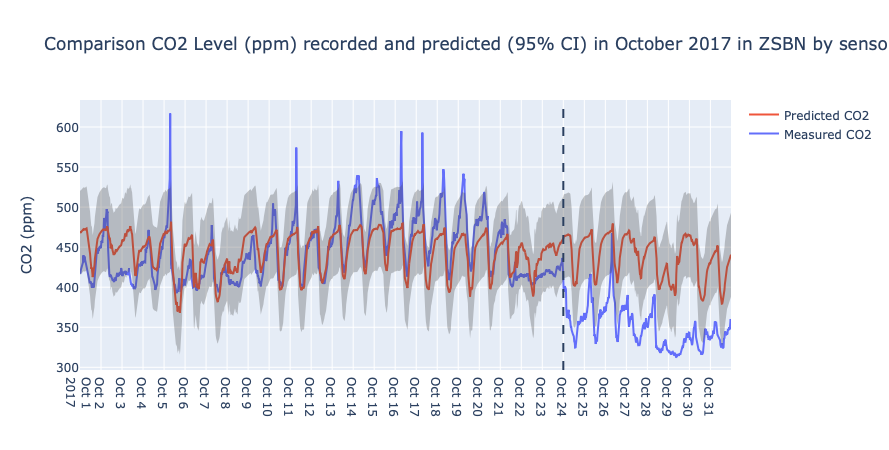

In [23]:
stdev = estimate_stdev(X_train)
plot_predicted_CO2(y_pred, stdev)

It was already showed through the plot in Section 3.a that the sensor 1031 in ZSBN has had a negative drift from 24 October on, and all the days after the values recorded were almost 100ppm smaller than the values recorded by sensors in similar areas. Similarly, a linear model using the humidity and temperature of October recorded by the same sensor (trained only until the 23 of October), shows that the expected (predicted) values of the CO2 recorded in ZSBN is higher (see red line in the graph above) with a quite strict 95% Confidence Interval (see green area in the graph above). It seems therefore that just humidity and temperature can already express a quite accurate raw estimate of the CO2 level.

### c) **10/35**

In your next attempt to solve the problem, you decide to exploit the fact that the CO2 concentrations, as measured by the sensors __experiencing similar conditions__, are expected to be similar.

- Find the sensors sharing similar conditions with `ZSBN`. Explain your definition of "similar condition".
- Fit a linear regression model to the CO2 measurements of the site, by considering as features:
    - the information of provided by similar sensors
    - the covariates associated with the faulty sensors that were not affected by the malfunction (such as temperature and humidity).
- Create an interactive plot with `plotly` (or other similar graphing libraries):
    - the actual CO2 measurements
    - the values obtained by the prediction of the linear model for the entire month of October
    - the __confidence interval__ obtained from cross validation
- What do you observe? Report your findings.

Standard deviation prediction: 8.757171088396175
95% Confident interval Prediction size: 34.328110666513005 ppm


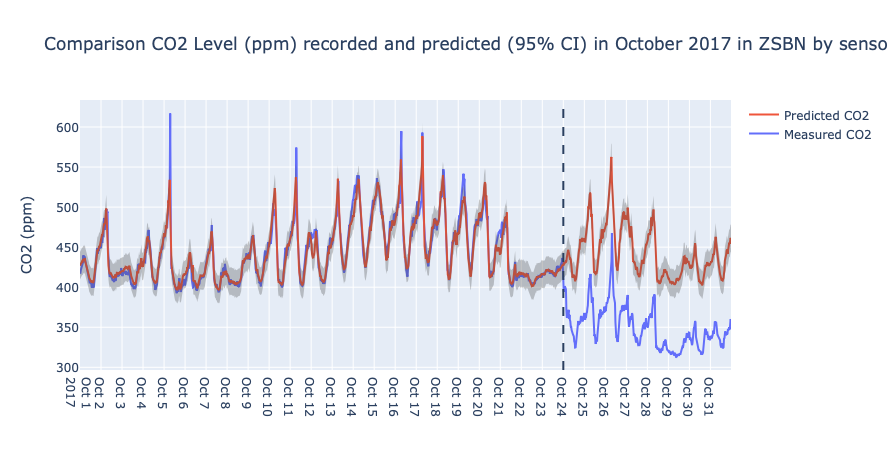

In [24]:
# Create the dataset. New features:
# - Humidity and Temperature of the sensor ID 1031 in ZSBN
# - CO2 level of all the sensors similar to ID 1031

dataset = data[-ZSBN & October & (same_zone | (close_lon & close_lat)) & close_alt][['timestamp','CO2','LocationName']]
dataset = dataset.set_index(['timestamp','LocationName']).unstack()['CO2'].dropna(axis='columns')
dataset = dataset.join(data[ZSBN].set_index(['timestamp'])[['humidity','temperature']])

X = dataset
X_train = X[ X.index.day<24 ]

# Prediction
linear_model.fit(X_train,y_train)
y_pred = linear_model.predict(X)


# Estimate Standard Deviation of the prediction
stdev = estimate_stdev(X_train)

# plot
plot_predicted_CO2(y_pred, stdev)

To have a better estimate of the missing data from the ZSBN sensor, we will use the CO2 information from similar sensors. Here, we define a similar sensor to ZSBN as a sensor which is in a similar location. By this, we mean a sensor in close altitude, and location on a map. The latter can be understood either as being in the same geographical zone or being close enough in term of the latitude and longitude.

To obtain an estimate of the missing values for the ZSBN sensor, we will use as regressors the humidity and temperature of this sensor, but also all the CO2 level recorded by the similar sensors. The 95% confidence interval is computed using cross validation to estimate the standard deviation and assuming normal error with no sensor bias.

We observe on the above figures the predicted CO2 measurement for the ZSBN sensor, compared to the actual measurement. From the 24th October we start seeing faulty observation, which has a negative drift. The linear regression computes a similar looking signal but without the shift. The confidence interval is tighter than the regression method with only humidity and temperature. We can conclude that this prediction provides an acceptable approximation of the CO2 level of the faulty sensor.


### d) **10/35**

Now, instead of feeding the model with all features, you want to do something smarter by using linear regression with fewer features.

- Start with the same sensors and features as in question c)
- Leverage at least two different feature selection methods
- Create similar interactive plot as in question c)
- Describe the methods you choose and report your findings

In [25]:
# feature selection 1
def F_test_f_selection(X, X_train, y_train=y_train, K=5):
    '''
    F-test features selector
    
    Input: X = features of the whole dataset (pd.Dataframe)
           X_train = features of the training dataset (pd.Dataframe)
           y_train = targets of the training set (pd.Series)
           K = number if features to select
    Output: X_r = whole dataset with the features selected (pd.Dataframe)
            X_train_r = training set with the features selected (pd.Dataframe)
    
    '''
    selector = sk.feature_selection.SelectKBest(sk.feature_selection.f_regression,k=K).fit(X_train,y_train)
    F, pvals = sk.feature_selection.f_regression(X_train,y_train)
    
    relevant_features = selector.get_support(indices=True)
    print('t-test featureS selection: selected {} features out of {} ({} discarded) ---> {}'
          .format(len(relevant_features), X.shape[1], X.shape[1]-len(relevant_features), list(X.columns[relevant_features])))
    X_r = X.iloc[:,relevant_features]
    X_train_r = X_train.iloc[:,relevant_features]
    return X_r, X_train_r

In [26]:
# feature selection 2
import statsmodels.api as sm

def t_test_f_selection(X, X_train, y_train=y_train, threshold = 0.05):
    '''
    t-test features selector
    
    Input: X = features of the whole dataset (pd.Dataframe)
           X_train = features of the training dataset (pd.Dataframe)
           y_train = targets of the training set (pd.Series)
           threshold = level of the t-test
    Output: X_r = whole dataset with the features selected (pd.Dataframe)
            X_train_r = training set with the features selected (pd.Dataframe)
    
    '''
    # train linear model
    res = sm.OLS(y_train, X_train_r1).fit()
    
    relevant_features = res.pvalues <= threshold
    print('F-test featureS selection: selected {} features out of {} ({} discarded) ---> {}'
          .format(len(relevant_features), X.shape[1], X.shape[1]-len(relevant_features), list(relevant_features.index)))
    X_r = X.loc[ :, relevant_features ]
    X_train_r = X_train.loc[ :, relevant_features ]
    return X_r, X_train_r

t-test featureS selection: selected 5 features out of 7 (2 discarded) ---> ['ZDLT', 'ZECB', 'ZHRG', 'ZHRZ', 'ZUE']
F-test featureS selection: selected 5 features out of 5 (0 discarded) ---> ['ZDLT', 'ZECB', 'ZHRG', 'ZHRZ', 'ZUE']
Standard deviation prediction: 8.93046215573979
95% Confident interval Prediction size: 35.007411650499975 ppm


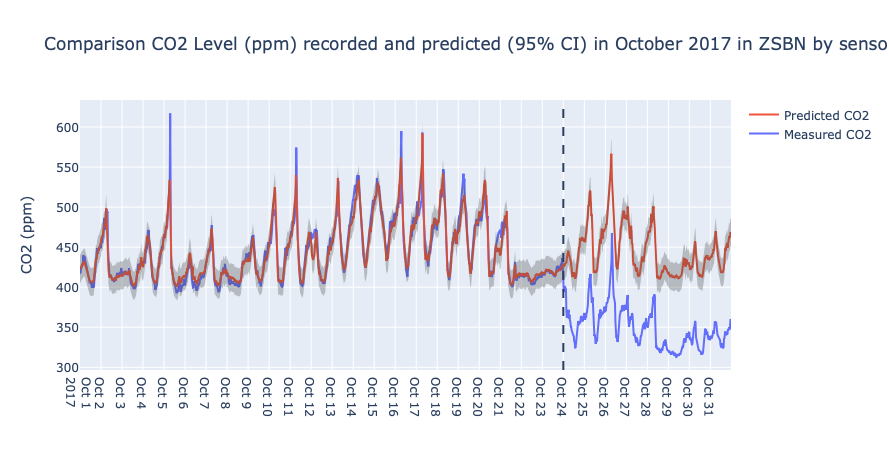

In [27]:
# features selection
X_r1, X_train_r1 = F_test_f_selection(X, X_train)
X_r2, X_train_r2 = t_test_f_selection(X_r1, X_train_r1)

# prediction
linear_model.fit(X_train_r2,y_train)
y_pred = linear_model.predict(X_r2)

# Create 95 Confidence Interval on prediction through Cross Validation
stdev = estimate_stdev(X_train_r2)

# plot
plot_predicted_CO2(y_pred, stdev)

First we propose to select features with respect to their individual correlation to the target variable (the CO2 emission of the ZSBN sensor) to filter only the most important features using the F-regression method. Then we consider the added value of each feature by evaluating the effect of removing it, in order to discard reduntant features, using the t-test on the coefficients of the linear regression. 

The F-regression method computes the correlation $\rho_i$ between each feature $i$ and the target variable, then derives the F-Statistic $F_i$ and it selects only the $K$ variables that have the highest F-Statistic. Our hope is that the features that are highly correlated to the target will be able to predict it accurately. In formula:

$$ \rho_{i}=\frac{(X[:, i]-\operatorname{mean}(X[:, i])) *(y-\operatorname{mean}(y))}{\operatorname{std}(X[:, i]) * s t d(y)}, \hspace{10pt} F_{i}=\frac{\rho_{i}^{2}}{1-\rho_{i}^{2}} *(n-2) $$

where $X$ is our set of samples, $y$ is our response variable and and $n$ is the number of samples.

From this method, we observe that the 5 features that are the most correlated to the response variable are the CO2 observation from the sensors ZDLT, ZECB, ZHRG, ZHRZ and ZUE. It is interesting to observe that the CO2 level of similar sensors is stronger correlated with the answer than the temperature and humidity of the same sensor: this is a great support on the rightness of our definition of similar sensors. 

The second criteria that we choose for features selection is a $t$-test on the coefficients of the trained linear model. In particular, for each coefficient $\beta_i$ of the linear model we consider the following test:
$$ H_{0}: \beta_i = 0 \qquad vs \qquad H_{1}: \beta_i \neq 0 $$
in other words we are asking if the feature $i$ is a relevant regressor for the model or it could be discarded (setting $\beta_i = 0$). The test statistic used for this test is: 
$$ T_0 = \frac{\hat{\beta}_i}{se(\hat{\beta}_i)} $$
where $\hat{\beta}_i$ is the least square estimate of  $\beta_i$, and $se(\hat{\beta}_i)$ is its standard error. The test statistic $T_0$ , follows a $t$ distribution with $(n−2)$ degrees of freedom, where $n$ is the total number of observations. The null hypothesis, $H_0$, is accepted if the calculated value of the test statistic is such that:
$$−t_{\alpha/2,n−2}<T_0<t_{\alpha/2,n−2}$$
Considering $\alpha = 0.05$ no one sensor is discarded by this second selector and the final features selected remain the CO2 observation from the sensors ZDLT, ZECB, ZHRG, ZHRZ and ZUE.

Training a new liner model only with the features selected we get a new prediction of the CO2 level observed by the ZSBN sensor. This prediction is very similar to that one before feature selection and also the 95% Confidence Interval size is almost the same. This means that the humidity and temperature of the sensor ZSBN are not realy necessary in order to reconstruct its CO2 level time series and that the measurements of the similar sensors are enough.

### e) **5/35**

Eventually, you'd like to try something new - __Bayesian Structural Time Series Modelling__ - to reconstruct counterfactual values, that is, what the CO2 measurements of the faulty sensor should have been, had the malfunction not happened on October 24. You will use:
- the information of provided by similar sensors - the ones you identified in question c)
- the covariates associated with the faulty sensors that were not affected by the malfunction (such as temperature and humidity).

To answer this question, you can choose between a Python port of the CausalImpact package (such as https://github.com/dafiti/causalimpact) or the original R version (https://google.github.io/CausalImpact/CausalImpact.html) that you can run in your notebook via an R kernel (https://github.com/IRkernel/IRkernel).

Before you start, watch first the [presentation](https://www.youtube.com/watch?v=GTgZfCltMm8) given by Kay Brodersen (one of the creators of the causal impact implementation in R), and this introductory [ipython notebook](http://nbviewer.jupyter.org/github/dafiti/causalimpact/blob/master/examples/getting_started.ipynb) with examples of how to use the python package.

- Report your findings:
    - Is the counterfactual reconstruction of CO2 measurements significantly different from the observed measurements?
    - Can you try to explain the results?

In [28]:
# No need to run it, the package is already installed
# ! pip install pycausalimpact

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency 30T will be used.

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency 30T will be used.



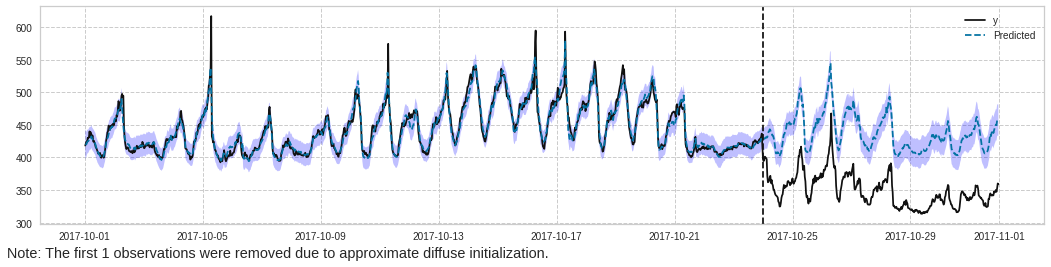

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    349.35             133800.79
Prediction (s.d.)         437.56 (5.16)      167584.29 (1976.37)
95% CI                    [427.21, 447.43]   [163619.82, 171367.05]

Absolute effect (s.d.)    -88.21 (5.16)      -33783.5 (1976.37)
95% CI                    [-98.08, -77.86]   [-37566.25, -29819.03]

Relative effect (s.d.)    -20.16% (1.18%)    -20.16% (1.18%)
95% CI                    [-22.42%, -17.79%] [-22.42%, -17.79%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [29]:
from datetime import datetime
from causalimpact import CausalImpact
import time

# The list of covariates we used in question 3.c
covariates = ['ZDLT', 'ZECB', 'ZHRG', 'ZHRZ', 'ZUE', 'humidity', 'temperature']
covariates_data = []
faulty_timestamp = datetime.strptime('24/10/2017 00:00:00', '%d/%m/%Y %H:%M:%S')
y = data[(data.LocationName == 'ZSBN')].set_index('timestamp')['CO2']

for i, cov in enumerate(covariates):
    covariates_data.append(dataset.iloc[:,i])

# We construct our dataframe to run our bayesian modeling from the similar sensors, conditions and our faulty censor 
bayesian_modeling_data = pd.DataFrame({'x0': covariates_data[0], 'x1': covariates_data[1], 'x2': covariates_data[2], 'x3': covariates_data[3],\
                                       'x4': covariates_data[4], 'x5': covariates_data[5], 'x6': covariates_data[6], 'y': y},\
                                      columns=['y', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5','x6'])

# Gets the the starting faulty timestamps from index
bayesian_modeling_data.reset_index(inplace=True)
faulty_timestamp_index = bayesian_modeling_data.timestamp[bayesian_modeling_data.timestamp == faulty_timestamp].index.tolist()

timestamps = bayesian_modeling_data.timestamp.tolist()
starting_timestamp = timestamps[0]
faulty_timestamp = timestamps[faulty_timestamp_index[0]]
faulty_timestamp_next = timestamps[faulty_timestamp_index[0]+1]
ending_timestamp = timestamps[-1]

bayesian_modeling_data.set_index(['timestamp'], inplace = True)

pre_period = [starting_timestamp, faulty_timestamp]
post_period = [faulty_timestamp_next, ending_timestamp]

# Running the model
ci = CausalImpact(bayesian_modeling_data, pre_period, post_period)

ci.plot(figsize=(18, 4), panels=['original'])
print(ci.summary())

We can see on the first graph above that the predictions are significantly different from the observed measurements as they fall way beyond the confidence intervals of our new model.   
Similarly to our previous results, we can observe the predicted CO2 levels for our drifting sensor seem very similar to the actual measurements but shifted up to the inital usual sensor CO2 level. The predictions are also a little smoother than the actual measurements.  
This makes sense as even with the drift, the faulty sensor still seems to detect similar CO2 variations as the other similar captors we identified. Maybe some part of the captor got obstructed and the remaining part only received a fraction of the CO2 which would explain why it still follows the general pattern.

# That's all, folks!